# Homework 3: Adding an LED to a Simple Energy Model Tutorial

The goal of this tutorial was to build a simple energy model using *MESSAGEix*. In addition to simple bulb in (``westeros_baseline.ipynb``), LED is added as a "light"-providing technology. 

3 tasks are accomplished within this homework:

- Introduce LED and show that the results of the baseline scenario (``westeros_baseline.ipynb``) do not change.
- Investigate under which carbon price the LED technology becomes economically viable.
- Assume different maximum diffusion rates for this new technology and compare the share of electricity from coal and wind depending on the diffusion rates (``westeros_baseline_LED.ipynb``).

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working
- You have run LED baseline scenario (``westeros_baseline.ipynb``) and solved it successfully


## Part 1: Comparing with the results of the ``westeros_baseline.ipynb``

### Initialization

First, we import all the packages we need. We import a utility function called *make_df*, which can be used to wrap the input data into dataframes that can be saved in model parameters. Then the *MESSAGEix* model is built using the *ixmp* `Platform`. The `Platform` is the connection to a database for storing model input data and scenario results.

In [605]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [606]:
mp = ixmp.Platform()

Once connected, we create a new `Scenario` to build our model. A `Scenario` instance will contain all the model input data and results.

In [607]:
model = 'Westeros Electrified'
base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen_led = base.clone(model, 'LED','introduction of LED technology in Westeros',
                  keep_solution=False)
scen_led.check_out()

In [608]:
year_df = scen_led.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen_led.set('year')
country = 'Westeros'

### Defining common keys

In order to define the input and output commodites of each technology, we define some common keys.

- **Input** quantities require `_origin` keys that specify where the inputs are *received from*.
- **Output** quantities require `_dest` keys that specify where the outputs are *transferred to*.

In [609]:
year_df = scen_led.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

### Introducing LED
The efficiency is assumed to be 1, i.e. it converts 100% of the electricity at "final" level to light at "useful" level. For models to be comparable, let's leave the effiiciency of a bulb at 100% as well.

In [610]:
scen_led.add_set("technology", ['LED'])

In [611]:
LED_out = make_df(base_output, technology='LED', commodity='light', 
                   level='useful', value=1.0)
scen_led.add_par('output', LED_out)

LED_in = make_df(base_input, technology='LED', commodity='electricity',  
                  level='final', value=1.0)
scen_led.add_par('input', LED_in)

### Defining Operational Parameters
#### Capacity factor

In [612]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

The capacity factor of LED is also 1, same as bulb, as there are no practical limits to their use.

In [613]:
capacity_factor = {
    'coal_ppl': 1,
    'wind_ppl': 0.36,
    'bulb': 1, 
    'LED': 1,
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scen_led.add_par('capacity_factor', df)

#### Lifetime

In [614]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

Average lifespan of LEDs is around 25 thousand hours vs. 1.2 thousand hours for incandescent light bulbs ([Ref](https://www.tomsguide.com/us/light-bulb-guide,review-1986.html)). This means that if simple bulbs operate around 1 year, LEDs can be functoning up to 20 years. However, considering the degradation of LEDs with time ([Ref](https://www.howtogeek.com/280843/do-led-light-bulbs-really-last-10-years/)) and if we consider that it works 7 hs a day 25000/365/7, let's assume it comes down to 5 years.

In [615]:
lifetime = {
    'coal_ppl': 20,
    'wind_ppl': 20,
    'bulb': 1,
    'LED': 5,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scen_led.add_par('technical_lifetime', df)

### Defining an Energy Mix (Model Calibration)

To model the transition of an energy system, one must start with the existing system which are defined by the parameters `historical_activity` and `historical_new_capacity`. These parameters define the energy mix before the model horizon.  

We begin by defining a few key values:

- how much useful energy was needed
- how much final energy was generated
- and the mix for different technologies (including the intial mix of bulb and LED, which is taken as 50%)

In [616]:
grid_efficiency = 0.9
demand_per_year = 40 * 12 * 1000 / 8760
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.6
bulb_fraction = 0.5

In [617]:
history = [690]
model_horizon = [700, 710, 720]

In [618]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

### Defining **Activity** and **Capacity** 

In [619]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'wind_ppl': (1 - coal_fraction) * historic_generation,
    'bulb' : bulb_fraction * historic_demand,
    'LED': (1-bulb_fraction) * historic_demand
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scen_led.add_par('historical_activity', df)

In [620]:
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, # 20 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
    'bulb': 1 / 10 / capacity_factor['LED'] / 0.1, 
    'LED': 1 / 10 / capacity_factor['LED'] / 0.5, 
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scen_led.add_par('historical_new_capacity', df)

### Objective Function

The objective function is to minimize total discounted system cost over space and time. 

$$\min \sum_{n,y \in Y^{M}} \text{interestrate}_{y} \cdot \text{COST_NODAL}_{n,y}$$


#### Interest rate

In [621]:
scen_led.add_par("interestrate", model_horizon, value=0.05, unit='-')

#### Investment Costs

In [622]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
#mp.add_unit('USD/kW')     

The specific investment cost of LED technology (USD/kW) is around 30 times larger - 1.5*1000/10 USD/kW ([Ref](https://www.tomsguide.com/us/light-bulb-guide,review-1986.html))

In [623]:
# in $ / kW (specific investment cost)
costs = {
    'coal_ppl': 500,
    'wind_ppl': 1500,
    'bulb': 5,
    'LED': 150,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scen_led.add_par('inv_cost', df)

### Solving the Model

First, we *commit* the model structure and input data (sets and parameters).
In the `ixmp` backend, this creates a new model version in the database, which is assigned a version number automatically:

In [624]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scen_led.version))

scen_led.commit(comment='Introduction of LED in Westeros')

log.info('version number prior committing to the database: {}'.format(scen_led.version))

An `ixmp` database can contain many scenarios, and possibly multiple versions of the same model and scenario name.
These are distinguished by unique version numbers.

To make it easier to retrieve the "correct" version (e.g., the latest one), you can set a specific scenario as the default version to use if the "Westeros Electrified" model is loaded from the `ixmp` database.

In [625]:
scen_led.solve()

In [626]:
scen_led.var('OBJ')['lvl']

238193.296875

### Plotting Results

We make use of some custom code for plotting the results; see `tools.py` in the tutorial directory.

In [627]:
from tools import Plots
p = Plots(scen_led, country, firstyear=model_horizon[0])

#### Activity - coal vs. wind

How much energy is generated in each time period from the different potential sources?

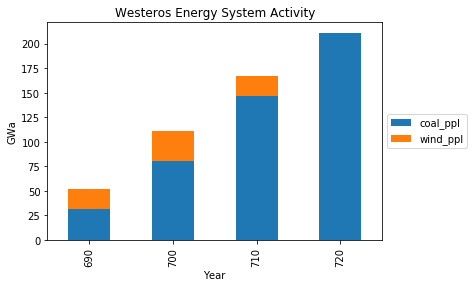

In [628]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

#### Capacity - coal vs. wind

How much capacity of each plant is installed in each period?

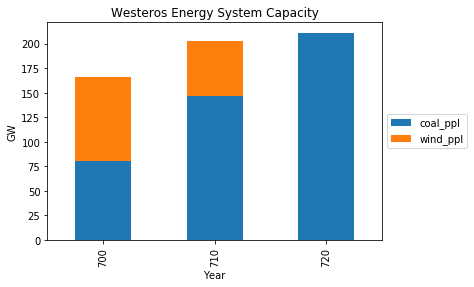

In [629]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

#### Activity - bulb vs. LED

How much electricity is consumed by bulb and LED in each period?

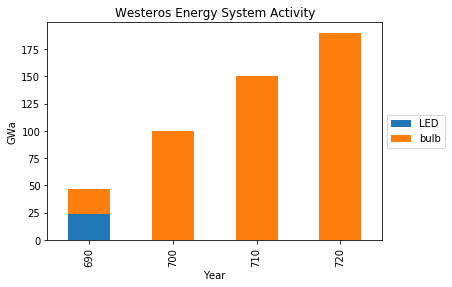

In [630]:
p.plot_activity(baseyear=True, subset=['bulb', 'LED'])

#### Capacity - bulb vs. LED

How much capacity of bulb and LED is installed in each period?

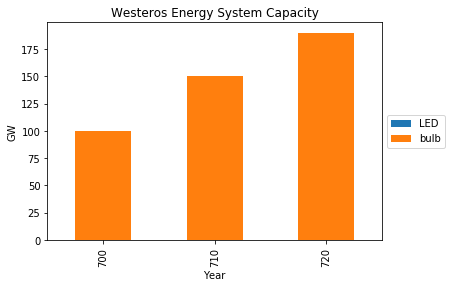

In [631]:
p.plot_capacity(baseyear=True, subset=['bulb', 'LED'])

#### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution.
They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of
electricity), which is in fact the marginal cost of the most expensive operating generator.  

Note the price drop when the most expensive technology is no longer in the system.

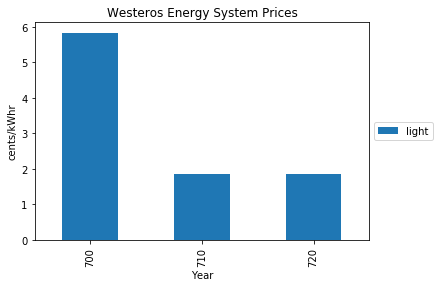

In [632]:
p.plot_prices(subset=['light'], baseyear=True)

In [633]:
scen_led.var('CAP')[12:]

,node_loc,technology,year_vtg,year_act,lvl,mrg
12,Westeros,bulb,700,700,100.0,0.0
13,Westeros,bulb,710,710,150.0,0.0
14,Westeros,bulb,720,720,190.0,0.0
15,Westeros,LED,700,700,0.0,0.0
16,Westeros,LED,710,710,0.0,0.0
17,Westeros,LED,720,720,0.0,0.0


### Results

As you can see, the results are the same as in ``westeros_baseline.ipynb``. This is because LED is too expensive. However, if the efficiency of bulb is reduced, then the electricity price in the first year (in 700) is high enough for LED to become viable. In that case, the total optimised price would be different from the baseline scenario.

## Part 2: Emission tax for LED to be economically viable

In this part, emission taxes are introduced. Higher emission taxes should increase the electricity price. As a result, LED might become economically competitive. The emission taxes will be found, such that LED is preferred in all 3 years of simulation. 

### Emissions

First, the previous scenario is cloned into a new one.

In [634]:
scen_led_tax = scen_led.clone (model, 'carbon_tax','introducing a carbon tax',
                      keep_solution=False)
scen_led_tax.check_out()

### Introducing Emissions

In [635]:
#base = {
 #   'node_loc': country,
  #  'year_vtg': vintage_years,
   # 'year_act': act_years,
#    'mode': 'standard',
 #   'time': 'year',
  #  'unit': '-',
#}

We **introduce carbon emissions** and the emission category - GHG and add CO2 emissions to the coal powerplant.

In [636]:
scen_led_tax.add_set('emission', 'CO2')
scen_led_tax.add_cat('emission', 'GHG', 'CO2')

base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

# adding new units to the model library (needed only once)
#mp.add_unit('tCO2/kWa')
#mp.add_unit('MtCO2')

emission_factor = make_df(base_emission_factor, technology= 'coal_ppl', emission= 'CO2', value = 7.4)
scen_led_tax.add_par('emission_factor', emission_factor)
scen_led_tax.par('emission_factor')

,node_loc,technology,year_vtg,year_act,mode,emission,value,unit
0,Westeros,coal_ppl,690,700,standard,CO2,7.4,tCO2/kWa
1,Westeros,coal_ppl,690,710,standard,CO2,7.4,tCO2/kWa
2,Westeros,coal_ppl,690,720,standard,CO2,7.4,tCO2/kWa
3,Westeros,coal_ppl,700,700,standard,CO2,7.4,tCO2/kWa
4,Westeros,coal_ppl,700,710,standard,CO2,7.4,tCO2/kWa
5,Westeros,coal_ppl,700,720,standard,CO2,7.4,tCO2/kWa
6,Westeros,coal_ppl,710,710,standard,CO2,7.4,tCO2/kWa
7,Westeros,coal_ppl,710,720,standard,CO2,7.4,tCO2/kWa
8,Westeros,coal_ppl,720,720,standard,CO2,7.4,tCO2/kWa


The **efficiency** of a bulb must be lowered for an LED to be uptaken. Otherwise, no matter how high the emission prices are, LED won't be viable.

In [637]:
bulb_out = make_df(base_output, technology='bulb', commodity='light', 
                   level='useful', value=0.9)
scen_led_tax.add_par('output', bulb_out)

bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  
                  level='final', value=1.0)
scen_led_tax.add_par('input', bulb_in)

**Emission prices** are given here. When the efficency of bulb is reduced, LED becomes economical in the first period (due to high electricity prices).

In [638]:
emission_prices= [0.,8., 8.]
#emission_prices

In [639]:
scen_led_tax.add_set('type_year', [700, 710, 720])

base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': emission_prices
}

# in case you need to add the new unit to the platform
#mp.add_unit('USD/tCO2')

tax_emission = make_df(base_tax_emission)
scen_led_tax.add_par('tax_emission', tax_emission)
scen_led_tax.par('tax_emission')

,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,0.0,USD/tCO2
1,Westeros,GHG,all,710,8.0,USD/tCO2
2,Westeros,GHG,all,720,8.0,USD/tCO2


### Solving the problem 

In [640]:
scen_led_tax.commit(comment='setting taxes on emissions')

In [641]:
scen_led_tax.solve()

### Plotting the results

In [642]:
from tools import Plots
a = Plots(scen_led_tax, country, firstyear=model_horizon[0])

#### Activity - LED vs bulb

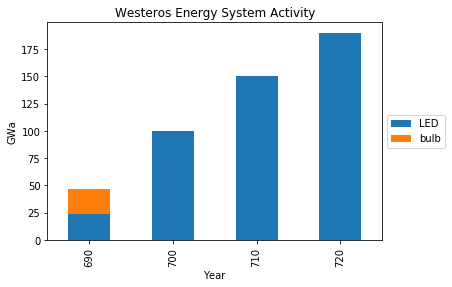

In [643]:
a.plot_activity(baseyear=True, subset=['bulb', 'LED'])

#### Capacity - LED vs bulb

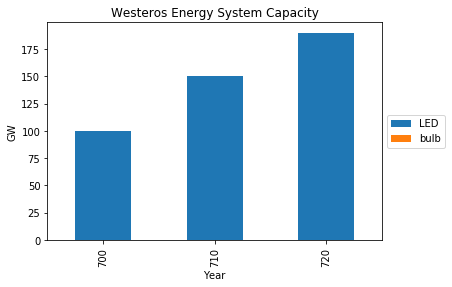

In [644]:
a.plot_capacity(baseyear=True, subset=['bulb', 'LED'])

At the threshold values of carbon tax (0, 8, 8) USD/tCO2 for periods (700, 710, 720) LED is more economical to adopt. 

### Part 3: Changing Diffusion Rate

In this part the diffusion rate of LED technology is introduced. It limits the ability for LED to **grow**. To do so, we  need to provide `growth_activity_up` values for each technology that we want to model as being diffusion constrained. In order to see its effect on coal and wind power plant mix, the extreme values like 0.001 and 1 should be compared.

In [645]:
scen_led_diff = scen_led_tax.clone(model, 'LED diffusion','changing diffusion rate of LED',
                  keep_solution=False)
scen_led_diff.check_out()

In [646]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

In [647]:
growth_technologies = [
    "LED",
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.001) 
    scen_led_diff.add_par('growth_activity_up', df)

In [648]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scen_led_diff.version))

scen_led_diff.commit(comment='Introduction of new diffusion rate for LED')

log.info('version number prior committing to the database: {}'.format(scen_led_diff.version))

In [649]:
scen_led_diff.solve()

In [650]:
from tools import Plots
b = Plots(scen_led_diff, country, firstyear=model_horizon[0])

### Capacity - LED vs. bulb
**With an upper limit on LED growth**

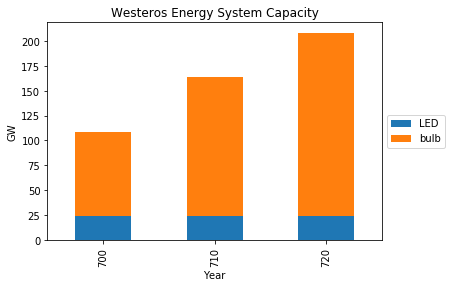

In [651]:
b.plot_capacity(baseyear=True, subset=['bulb', 'LED'])

**Without an upper limit on LED growth**

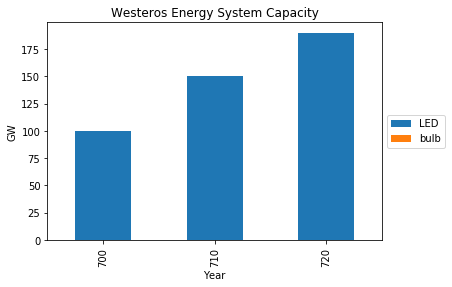

In [652]:
a.plot_capacity(baseyear=True, subset=['bulb', 'LED'])

### Capacity - wind vs. coal

**With an upper limit on LED growth**

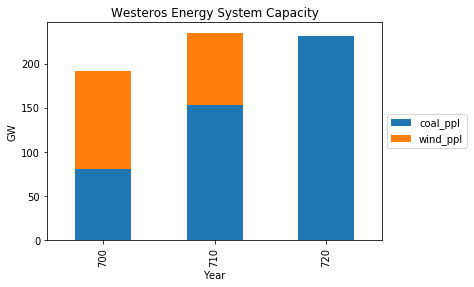

In [653]:
b.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

In [662]:
#to see if the values are really different
#scen_led_diff.var('CAP')[:12]

,node_loc,technology,year_vtg,year_act,lvl,mrg
0,Westeros,coal_ppl,690,700,15.525114,0.000000
1,Westeros,coal_ppl,700,700,65.011181,0.000000
2,Westeros,coal_ppl,700,710,65.011181,0.000000
3,Westeros,coal_ppl,710,710,87.574415,0.000000
4,Westeros,coal_ppl,710,720,87.574415,0.000000
5,Westeros,coal_ppl,720,720,144.030952,0.000000
6,Westeros,wind_ppl,690,700,28.750211,0.000000
7,Westeros,wind_ppl,700,700,82.406993,0.000000
8,Westeros,wind_ppl,700,710,82.406993,0.000000
9,Westeros,wind_ppl,710,710,0.000000,241.046596


**Without an upper limit on LED growth**

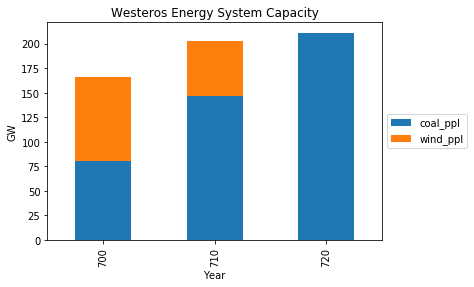

In [654]:
a.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

In [663]:
#scen_led_tax.var('CAP')[:12]

,node_loc,technology,year_vtg,year_act,lvl,mrg
0,Westeros,coal_ppl,690,700,15.525114,0.000000
1,Westeros,coal_ppl,700,700,65.011181,0.000000
2,Westeros,coal_ppl,700,710,65.011181,0.000000
3,Westeros,coal_ppl,710,710,81.430746,0.000000
4,Westeros,coal_ppl,710,720,81.430746,0.000000
5,Westeros,coal_ppl,720,720,129.680365,0.000000
6,Westeros,wind_ppl,690,700,28.750211,0.000000
7,Westeros,wind_ppl,700,700,56.179832,0.000000
8,Westeros,wind_ppl,700,710,56.179832,0.000000
9,Westeros,wind_ppl,710,710,0.000000,241.046596


### Results
One can see that putting a cap on the LED growth can limit its uptake. The lower these limits are, the larger the share of wind power plants in the energy mix. This is because the problem tries to reduce the costs for carbon emissions. 

## Close the connection to the database

When working with local HSQLDB database instances, you cannot connect to one database from multipe Jupyter notebooks (or processes) at the same time.

If you want to easily switch between notebooks with connections to the same `ixmp` database, you need to close the connection in one notebook before initializing the platform using `ixmp.Platform()` in another notebook.

After having closed the database connection, you can reopen it using
```
mp.open_db()
```

In [655]:
mp.close_db()

## Congratulations! 

You have built and run your very first *MESSAGEix* model. Welcome to the community!

The next tutorials will introduce you to other features of the framework, including energy system constraints, emissions taxes, and other policy options.

Check us out on Github https://github.com/iiasa/message_ix  
and get in touch with us online https://groups.google.com/forum/message-ix ...